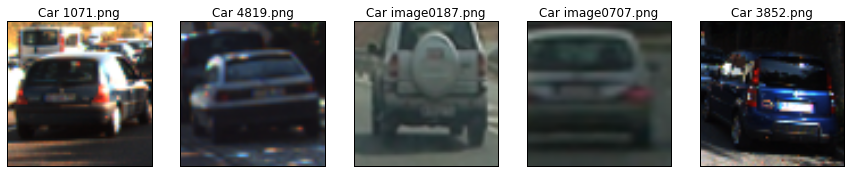

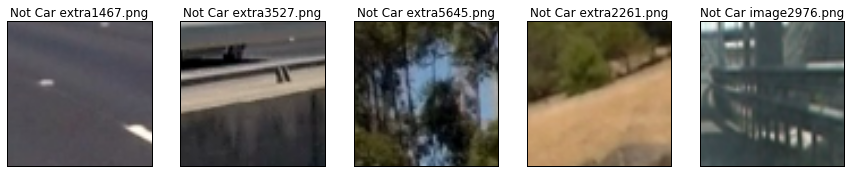

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

car_images = glob.glob('./Training/vehicles/*/*.png')
notcar_images = glob.glob('./Training/non-vehicles/*/*.png')

class ImageInfo:
    def __init__(self, img, title=None, cmap=None):
        self.img = img
        self.title = title
        self.cmap = cmap

def get_random_examples(img_files, pfx='', num_examples=5):
    examples = []
    for i in np.random.randint(0, high=len(img_files), size=num_examples):
        image = mpimg.imread(img_files[i])
        title = pfx + ' ' + img_files[i].split('/')[-1]
        examples.append(ImageInfo(image, title))
    return examples

def plot_images(img_list, size=(15,5), ncols=5):
    nrows=(len(img_list) + ncols - 1)//ncols
    plt.figure(figsize=size)
    pltnum = 1
    for imginfo in img_list:
        plt.subplot(nrows, ncols, pltnum)
        plt.imshow(imginfo.img, cmap=imginfo.cmap)
        if imginfo.title is not None:
            plt.title(imginfo.title, fontdict={'fontsize':12})
        plt.xticks([])
        plt.yticks([])
        pltnum += 1

car_examples = get_random_examples(car_images, pfx='Car')
plot_images(car_examples)

notcar_examples = get_random_examples(notcar_images, pfx='Not Car')
plot_images(notcar_examples)

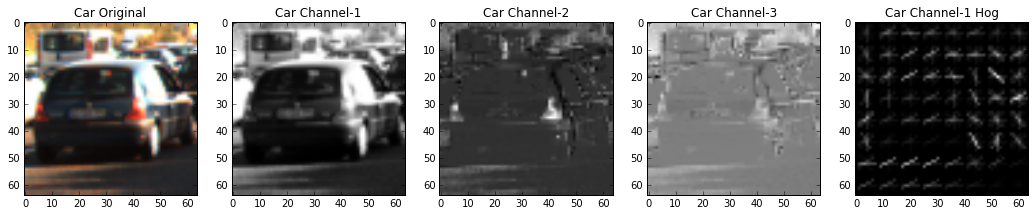

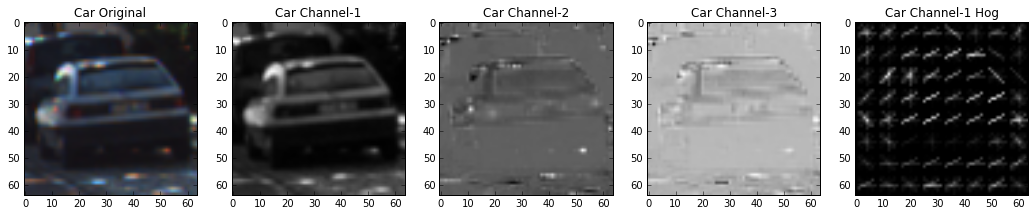

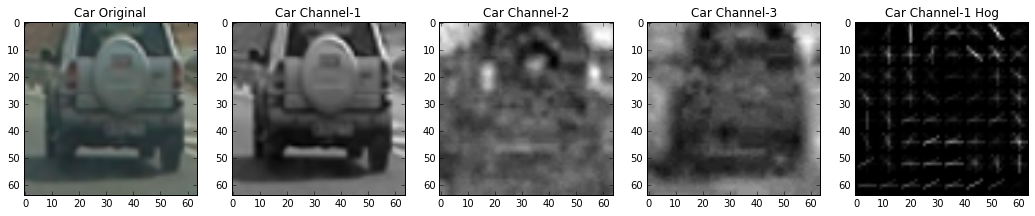

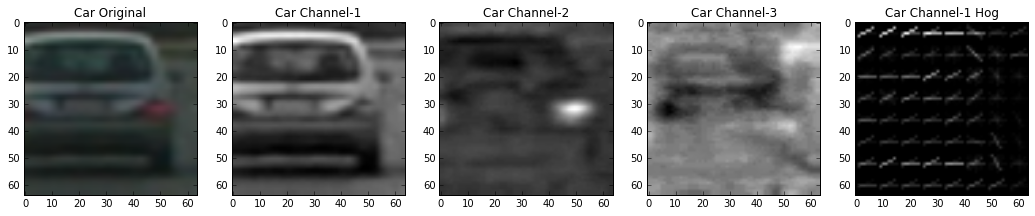

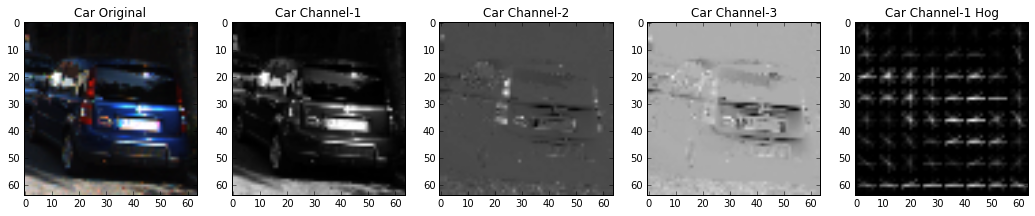

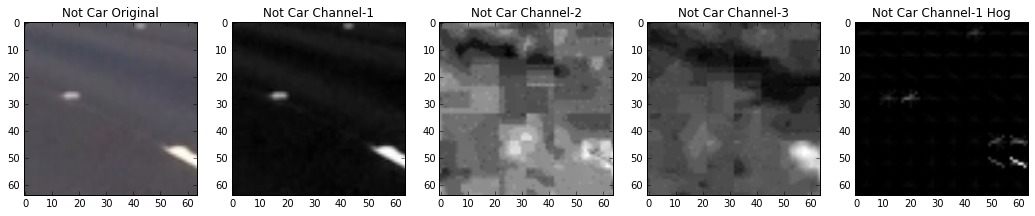

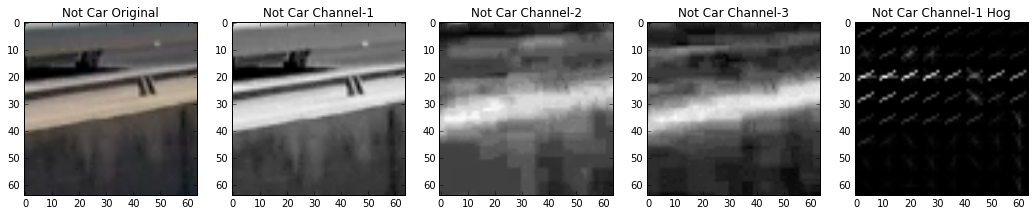

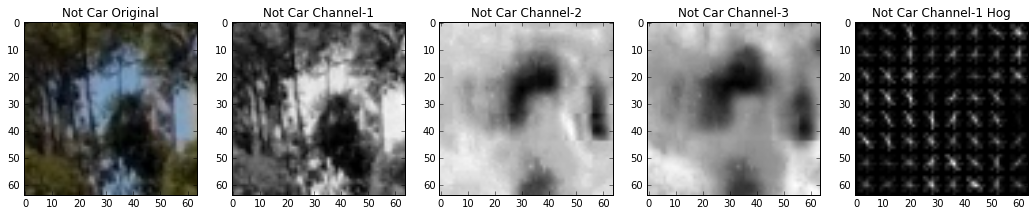

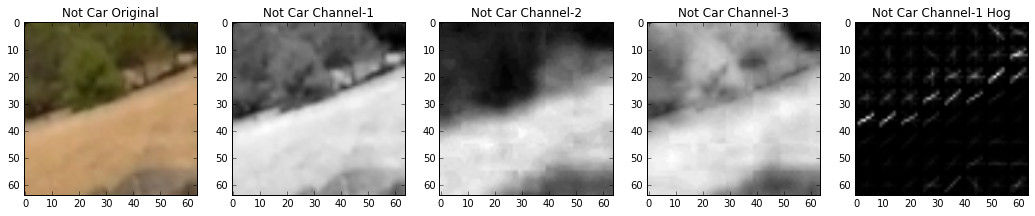

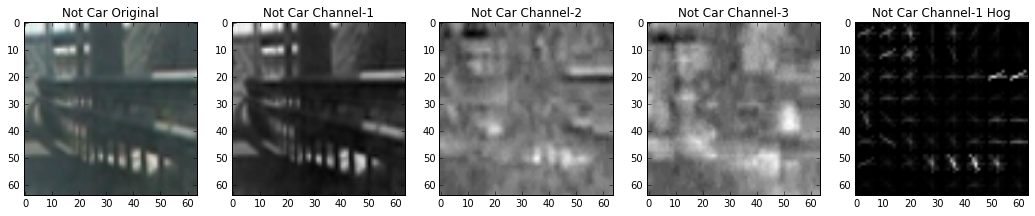

In [3]:
import cv2
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

def test_hog_features(img, prefix):
    cvt_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    channel_1 = cvt_image[:,:,0]
    channel_2 = cvt_image[:,:,1]
    channel_3 = cvt_image[:,:,2]
    features, hog_image = get_hog_features(channel_1, orient=8, pix_per_cell=8,
                                           cell_per_block=2, vis=True, feature_vec=False)
    fig, axs = plt.subplots(ncols=5, figsize=(18,5))
    axs[0].imshow(img)
    axs[0].set_title(prefix + ' Original')
    axs[1].imshow(channel_1, cmap='gray')
    axs[1].set_title(prefix + ' Channel-1')
    axs[2].imshow(channel_2, cmap='gray')
    axs[2].set_title(prefix + ' Channel-2')
    axs[3].imshow(channel_3, cmap='gray')
    axs[3].set_title(prefix + ' Channel-3')
    axs[4].imshow(hog_image, cmap='gray')
    axs[4].set_title(prefix + ' Channel-1 Hog')

for i in range(len(car_examples)):
    test_hog_features(car_examples[i].img, prefix='Car')
    
for i in range(len(notcar_examples)):
    test_hog_features(notcar_examples[i].img, prefix='Not Car')

In [4]:
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

In [25]:
from tqdm import tqdm

def single_img_features(img, color_space='RGB', spatial_size=(32,32), hist_bins=32,
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feature=True, hist_feature=True, hog_feature=True):
    file_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'Lab':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    if spatial_feature:
        file_features.append(bin_spatial(img, size=spatial_size))
    if hist_feature:
        file_features.append(color_hist(img, nbins=hist_bins))
    if hog_feature:
        features_hog = []
        if hog_channel == 'ALL':
            for channel in range(img.shape[2]):
                features_hog.append(get_hog_features(img[:,:,channel], orient, pix_per_cell, cell_per_block))
        else:
            features_hog.append(get_hog_features(img[:,:,hog_channel], orient, pix_per_cell, cell_per_block))
        
        features_hog = np.ravel(features_hog)
        file_features.append(features_hog)

    return np.concatenate(file_features)

def extract_features(imgs, desc, color_space='RGB', spatial_size=(32,32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feature=True, hist_feature=True, hog_feature=True):
    features = []
    for im_file in tqdm(imgs, desc):
        img = mpimg.imread(im_file)
        single_features = single_img_features(img, color_space, spatial_size, hist_bins,
                                              orient, pix_per_cell, cell_per_block, hog_channel,
                                              spatial_feature, hist_feature, hog_feature)
        features.append(single_features)
    return features
    
# Parameters to extract features
color_space = 'LUV'
spatial_size=(16,16)
hist_bins=16
orient = 8
pix_per_cell = 10
cell_per_block = 2
hog_channel = 0

car_features = extract_features(car_images, 'Extracting car features', color_space, spatial_size, \
                                hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)

notcar_features = extract_features(notcar_images, 'Extracting not car features', color_space, spatial_size, \
                                   hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)

Extracting not car features: 100%|██████████| 8968/8968 [00:22<00:00, 400.19it/s]


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

In [27]:
from sklearn.svm import LinearSVC

svc = LinearSVC(verbose=1)
svc.fit(X_train, y_train)
print('Test Accuracy = ', round(svc.score(X_test, y_test), 4))

[LibLinear]Test Accuracy =  0.9761


/home/rajat/miniconda3/envs/carnd-term1/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


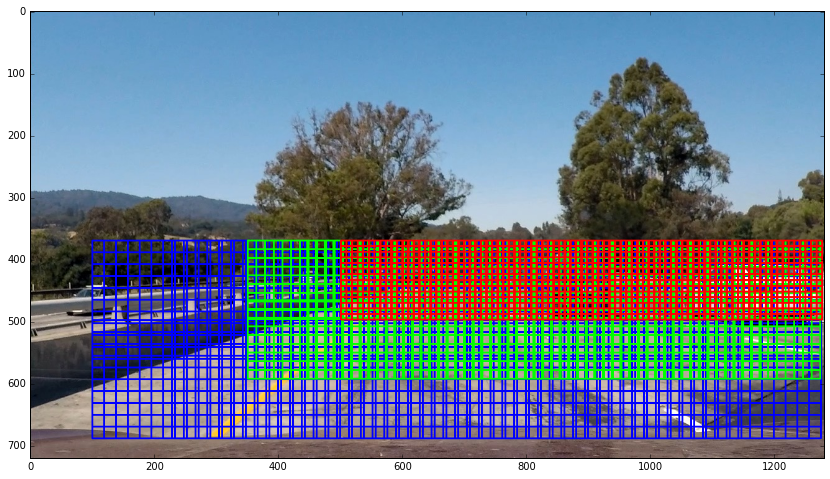

In [28]:
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=2):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    window_list = []
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    x_pix_per_step = int(xy_window[1]*(1 - xy_overlap[1]))
    y_pix_per_step = int(xy_window[0]*(1 - xy_overlap[0]))
    x_last_no_overlap = int(xy_window[1]*xy_overlap[1])
    y_last_no_overlap = int(xy_window[0]*xy_overlap[0])
    nx_windows = (x_span - x_last_no_overlap)//x_pix_per_step
    ny_windows = (y_span - y_last_no_overlap)//y_pix_per_step

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*x_pix_per_step + x_start_stop[0]
            starty = ys*y_pix_per_step + y_start_stop[0]
            endx = startx + xy_window[1]
            endy = starty + xy_window[0]
            window = ((startx, starty), (endx, endy))
            window_list.append(window)
    return window_list

def create_multiscale_windows(img, display=False):
    window_list = []
  
    windows = slide_window(img, x_start_stop=[100, None], y_start_stop=[370, 700],
                           xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    if display:
        win_img = draw_boxes(img, windows, color=(0,0,255))
    window_list += windows

    windows = slide_window(img, x_start_stop=[350, None], y_start_stop=[370, 600],
                           xy_window=(96, 96), xy_overlap=(0.85, 0.85))
    if display:
        win_img = draw_boxes(win_img, windows, color=(0,255,0))
    window_list += windows
    
    windows = slide_window(img, x_start_stop=[500, None], y_start_stop=[370, 500],
                           xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    if display:
        win_img = draw_boxes(win_img, windows, color=(255, 0, 0))
    window_list += windows
    
    if display:
        plt.figure(figsize=(15,8))
        plt.imshow(win_img)
            
    return window_list

test_img = mpimg.imread('./test_images/test1.jpg')
windows = create_multiscale_windows(test_img, display=True)

In [29]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32,32), hist_bins=32, orient=9,
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feature=True, hist_feature=True, hog_feature=True):
    windows_match = []
    for window in windows:
        window_crop = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = single_img_features(window_crop, color_space, spatial_size, hist_bins,
                                       orient, pix_per_cell, cell_per_block, hog_channel,
                                       spatial_feature, hist_feature, hog_feature)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            windows_match.append(window)
    
    return windows_match

detected_images = []
for test_file in sorted(glob.glob('./test_images/test*.jpg')):
    test_img = mpimg.imread(test_file)
    windows = create_multiscale_windows(test_img)
    hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space, spatial_size, \
                                 hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)
    win_img = draw_boxes(test_img, hot_windows)
    title = test_file.split('/')[-1]
    detected_images.append(ImageInfo(win_img, title))

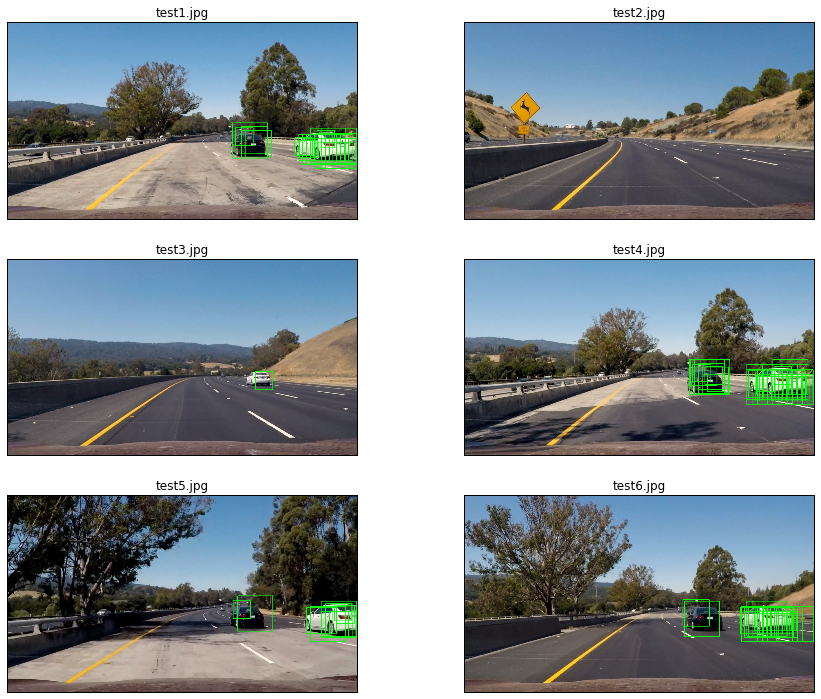

In [30]:
plot_images(detected_images, size=(15,12), ncols=2)

In [31]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, hot_windows):
    for window in hot_windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold=1):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    img_copy = np.copy(img)
    for label_val in range(1, labels[1]+1):
        nonzero = (labels[0] == label_val).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img_copy, bbox[0], bbox[1], (0,255,0), 6)
    return img_copy
    
display_images = []
for test_file in sorted(glob.glob('./test_images/test*.jpg')):
    test_img = mpimg.imread(test_file)
    windows = create_multiscale_windows(test_img)
    hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space, spatial_size, \
                                 hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)
    heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap)
    heatmap = np.clip(heatmap, 0, 255)
    title = test_file.split('/')[-1]
    display_images.append(ImageInfo(heatmap, title=title + ': Heatmap', cmap='hot'))
    
    labels = label(heatmap)
    display_images.append(ImageInfo(labels[0], title=title + ': Label', cmap='gray'))
    
    output_image = draw_labeled_bboxes(test_img, labels)
    display_images.append(ImageInfo(output_image, title=title + ': Output'))

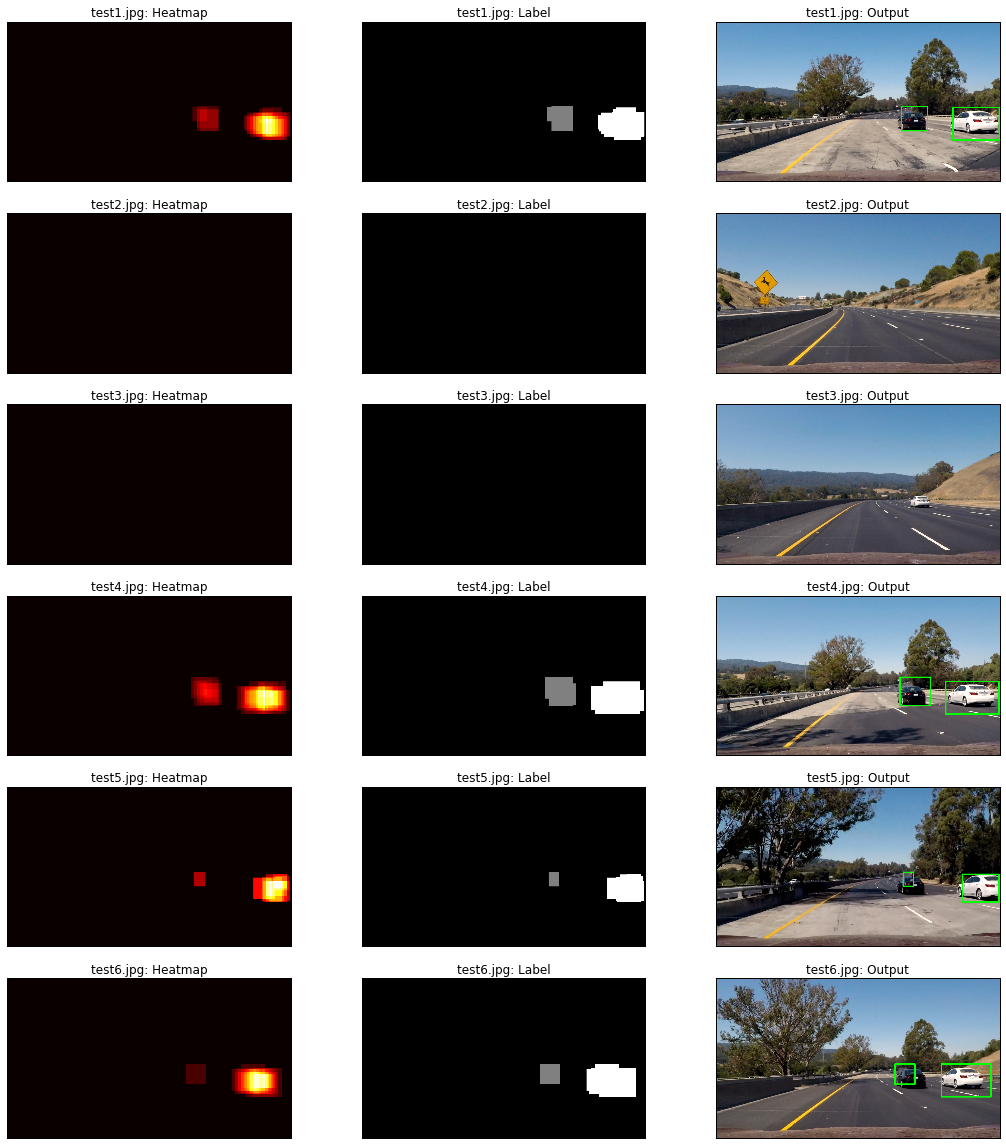

In [32]:
plot_images(display_images, size=(18, 20), ncols=3)

In [33]:
def detect_cars(img):
    windows = create_multiscale_windows(img)
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space, spatial_size, \
                                 hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)
    heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap)
    labels = label(heatmap)
    output_image = draw_labeled_bboxes(img, labels)
    return output_image

In [35]:
#from AdvanceLaneFinding import LaneDetector

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_file="test_video.mp4"
output_video = "output_images/" + video_file
clip = VideoFileClip("./" + video_file)
#lane_detect = LaneDetector(debug=True)
#marked_clip = clip.fl_image(lane_detect.process_frame)
marked_clip = clip.fl_image(detect_cars)
%time marked_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4


 97%|█████████▋| 38/39 [02:44<00:04,  4.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 

CPU times: user 2min 44s, sys: 68 ms, total: 2min 44s
Wall time: 2min 46s


In [ ]:
video_file="project_video.mp4"
output_video = "output_images/" + video_file
clip = VideoFileClip("./" + video_file)
#lane_detect = LaneDetector(debug=True)
#marked_clip = clip.fl_image(lane_detect.process_frame)
marked_clip = clip.fl_image(detect_cars)
%time marked_clip.write_videofile(output_video, audio=False)